<a href="https://colab.research.google.com/github/GenevieveAN/GA4-BigQuery-Marketing-Analytics/blob/main/Multi_Touch_Attribution_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MULTI-TOUCH ATTRIBUTION MODEL FOR BEAT WEEK FUNDRAISING CAMPAIGN - 2025**

**Author**: Genevieve Antwi-Nuamah

**Date**: November 2024

**Dataset**: GA4 visits and E-commerce transactions between 12th October 2025 and 28th Octoer 2025

**OVERVIEW**

Analysis of marketing channel performance using GA4 BigQuery data (120k+ events). Compares three attribution models to reveal how channels work together.

**Key Finding**: 89.7% single-touch conversions. This campaign is optimized for immediate response, not nurture

**Models**: Last-touch(baseline | Linear (equal credit) | Position-based (40/20/40)

**1.Setup and Authentication**

In [ ]:

# Authenticate with Google Cloud
from google.colab import auth
auth.authenticate_user()

# Explicitly set credentials
import google.auth
credentials, project = google.auth.default()

print(f"✅ Authenticated!")
print(f"Default project: {project}")

# Now explicitly create client with credentials
from google.cloud import bigquery
client = bigquery.Client(project='beat-week-test', credentials=credentials)

# Test it
query = """
SELECT COUNT(*) as test
FROM `beat-week-test.analytics_409833742.events_*`
LIMIT 1
"""

result = client.query(query).to_dataframe()
print(f"✅ Connection successful!")
print(result)



✅ Authenticated!
Default project: 
✅ Connection successful!
     test
0  123974


In [ ]:
!pip install -q google-cloud-bigquery pandas matplotlib seaborn
print ("Packages installed!")

Packages installed!


**2.** **Attribution Model Class**

**Architecture**: Object-oriented for reusability


**Methods**:
  - `get_channel_grouping_sql()`: Custom channel taxonomy
  - `extract_journeys()`: Pull data from BigQuery
  - `calculate_attribution()`: Apply attribution logic
  - `compare models()`: Run all 3 models
  - `visualize()`: Create comparison charts

In [ ]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns

class GA4Attribution:
  """
  Multi-touch attribution model for GA4 Bigquery data.
  Supports: last_touch, linear, position_based
  """
  def __init__(self, project_id, dataset_id):
    self.client = bigquery.Client(project=project_id)
    self.project_id = project_id
    self.dataset_id = dataset_id

  def get_channel_grouping_sql(self):
    return """
 CASE
 WHEN traffic_source.source = '(direct)'
 AND (traffic_source.medium = '(none)' OR traffic_source.medium = '(not set)' OR traffic_source.medium IS NULL)
 THEN 'Direct'
 WHEN (traffic_source.source = 'google' OR traffic_source.source LIKE '%FY26_paid%')
 AND traffic_source.medium = 'cpc'
 THEN 'Paid Search'
 WHEN traffic_source.source = 'fbig' AND traffic_source.medium = 'traffic'
 THEN 'Paid Social'
 WHEN traffic_source.source IS NULL AND traffic_source.medium = 'traffic'
 THEN 'Paid Social'
 WHEN traffic_source.source = 'MarketingCloud' OR traffic_source.medium = 'email'
 THEN 'Email'
 WHEN traffic_source.source IN ('(organic)', 'google') AND traffic_source.medium = 'organic'
 THEN 'Organic Search'
 WHEN traffic_source.medium = 'referral'
 AND traffic_source.source LIKE '%facebook%'
 THEN 'Organic Social'
 WHEN traffic_source.medium = 'referral'
 THEN 'Referral'
 ELSE 'Other'
 END
 """

  def extract_customer_journeys(self, start_date, end_date, conversion_event='purchase', lookback_days=30):
    channel_grouping_sql = self.get_channel_grouping_sql()

    query = f"""
 WITH all_sessions AS (
 SELECT
 user_pseudo_id,
 event_timestamp,
 traffic_source.source,
 traffic_source.medium,
 {channel_grouping_sql} as channel_grouping
 FROM `{self.project_id}.{self.dataset_id}.events_*`
 WHERE _TABLE_SUFFIX BETWEEN '{start_date}' AND '{end_date}'
 AND event_name = 'session_start'
 ),
 conversions AS (
 SELECT
 user_pseudo_id,
 MIN(event_timestamp) as conversion_timestamp,
 SUM(ecommerce.purchase_revenue) as total_revenue
 FROM `{self.project_id}.{self.dataset_id}.events_*`
 WHERE _TABLE_SUFFIX BETWEEN '{start_date}' AND '{end_date}'
 AND event_name = '{conversion_event}'
 GROUP BY user_pseudo_id
 ),
 customer_journeys AS (
 SELECT
 s.user_pseudo_id,
 s.event_timestamp as touchpoint_timestamp,
 s.channel_grouping,
 c.conversion_timestamp,
 c.total_revenue,
 ROW_NUMBER() OVER (PARTITION BY s.user_pseudo_id ORDER BY s.event_timestamp) as touchpoint_position,
 COUNT(*) OVER (PARTITION BY s.user_pseudo_id) as total_touchpoints
 FROM all_sessions s
 INNER JOIN conversions c ON s.user_pseudo_id = c.user_pseudo_id
 WHERE s.event_timestamp <= c.conversion_timestamp
 AND s.event_timestamp >= c.conversion_timestamp - ({lookback_days} * 24 * 60 * 60 * 1000000)
 )
 SELECT * FROM customer_journeys
 ORDER BY user_pseudo_id, touchpoint_timestamp
 """

    print(f"Querying BigQuery...")
    df = self.client.query(query).to_dataframe()
    print(f"✅ Got {len(df)} touchpoints for {df['user_pseudo_id'].nunique()} customers")
    return df

  def calculate_attribution(self, journeys_df, model='position_based'):
    results = []
    for user_id, journey in journeys_df.groupby('user_pseudo_id'):
      n = journey['total_touchpoints'].iloc[0]
      revenue = journey['total_revenue'].iloc[0] if pd.notna(journey['total_revenue'].iloc[0]) else 0

      for idx, row in journey.iterrows():
        pos = row['touchpoint_position']

        if model == 'linear':
          credit = 1.0 / n
        elif model == 'position_based':
          if n == 1: credit = 1.0
          elif n == 2: credit = 0.5
          else: credit = 0.4 if pos in [1, n] else 0.2 / (n - 2)
        elif model == 'last_touch':
          credit = 1.0 if pos == n else 0.0

        results.append({
            'user_id': user_id,
            'channel': row['channel_grouping'],
            'credit': credit,
            'attributed_revenue': revenue * credit
        })

    return pd.DataFrame(results)

  def compare_models(self, journeys_df):
    comparison = []
    for model in ['last_touch', 'linear', 'position_based']:
      print(f" Calculating {model}...")
      attr = self.calculate_attribution(journeys_df, model)
      summary = attr.groupby('channel').agg({'credit': 'sum', 'attributed_revenue': 'sum'}).reset_index()
      summary['model'] = model
      comparison.append(summary)
    return pd.concat(comparison, ignore_index=True)

  def visualize(self, comparison_df):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    pivot_conv = comparison_df.pivot(index='channel', columns='model', values='credit')
    pivot_conv = pivot_conv[['last_touch', 'linear', 'position_based']]
    pivot_conv.plot(kind='bar', ax=axes[0], color=['#e74c3c', '#3498db', '#2ecc71'])
    axes[0].set_title('Attributed Conversions', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Conversions')
    axes[0].legend(['Last-Touch', 'Linear', 'Position-Based'])
    axes[0].grid(axis='y', alpha=0.3)

    pivot_rev = comparison_df.pivot(index='channel', columns='model', values='attributed_revenue')
    pivot_rev = pivot_rev[['last_touch', 'linear', 'position_based']]
    pivot_rev.plot(kind='bar', ax=axes[1], color=['#e74c3c', '#3498db', '#2ecc71'])
    axes[1].set_title('Attributed Revenue', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Revenue ($)')
    axes[1].legend(['Last-Touch', 'Linear', 'Position-Based'])
    axes[1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

print("✅ GA4Attribution loaded!")

✅ GA4Attribution loaded!


**3.Run Analysis**

Configuration:
  - Campaign: Oct 12-28, 2025
  - Lookback:30 days
  - Conversion: 'purchase' event

In [ ]:
# Initialize
ga4 = GA4Attribution(project_id='beat-week-test', dataset_id='analytics_409833742')

# Extract journeys
journeys = ga4.extract_customer_journeys(
 start_date='20251012',
 end_date='20251028',
 conversion_event='purchase',
 lookback_days=30
)

# Calculate attribution
print("\nCalculating attribution...")
comparison = ga4.compare_models(journeys)

# Show results
position = comparison[comparison['model'] == 'position_based'].sort_values('credit', ascending=False)
print("\n" + "="*60)
print("POSITION-BASED ATTRIBUTION")
print("="*60)
print(position[['channel', 'credit', 'attributed_revenue']])

Querying BigQuery...
✅ Got 1451 touchpoints for 1109 customers

Calculating attribution...
 Calculating last_touch...
 Calculating linear...
 Calculating position_based...

POSITION-BASED ATTRIBUTION
           channel  credit  attributed_revenue
17           Email   448.0          25020.6942
16          Direct   333.0          13674.4400
19  Organic Social    90.0           2319.0000
23        Referral    78.0           2745.0000
20           Other    74.0           2360.0000
18  Organic Search    57.0           5285.0000
21     Paid Search    22.0            395.0000
22     Paid Social     7.0            140.0000


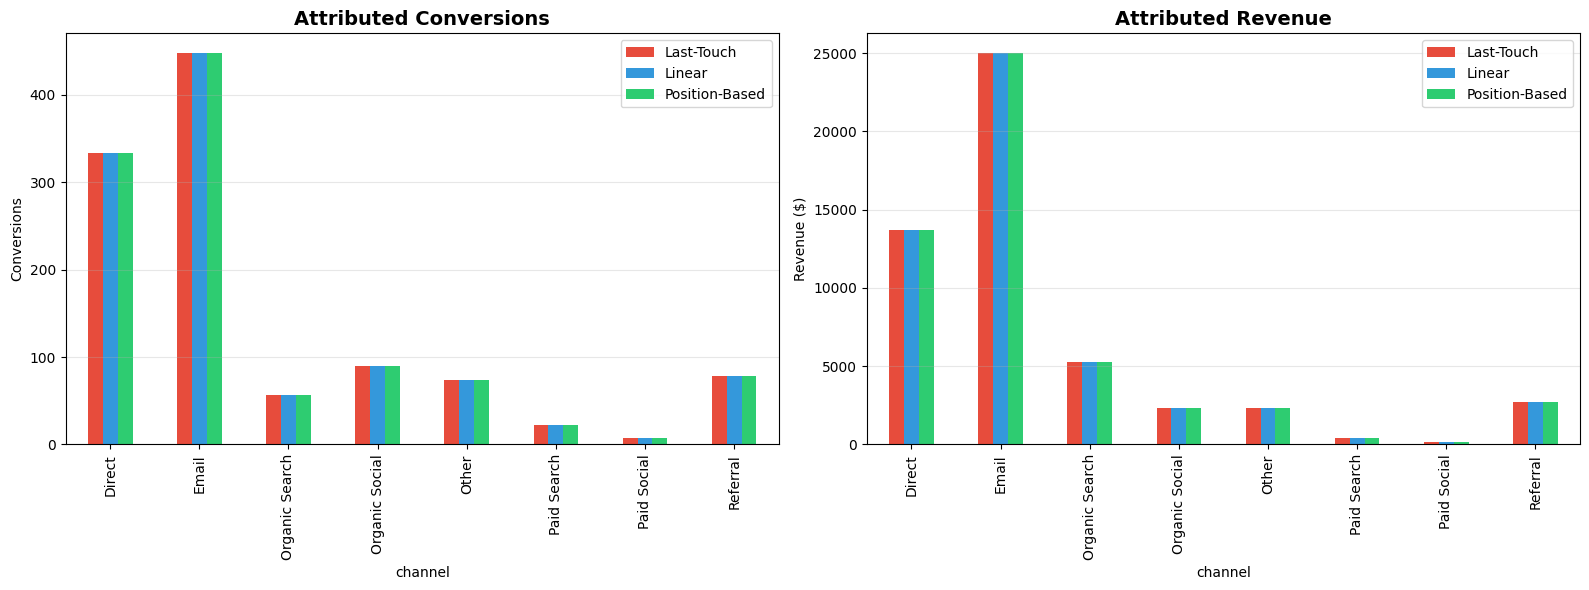

In [ ]:
ga4.visualize(comparison)

In [ ]:
def visualize(self, comparison_df):
 fig, axes = plt.subplots(1, 2, figsize=(16, 6))

 # Conversions chart
 pivot = comparison_df.pivot(index='channel', columns='model', values='credit')
 pivot = pivot[['last_touch', 'linear', 'position_based']]
 pivot.plot(kind='bar', ax=axes[0])
 axes[0].set_title('Attributed Conversions', fontsize=14, fontweight='bold')
 axes[0].set_ylabel('Conversions')
 axes[0].legend(['Last-Touch', 'Linear', 'Position-Based'])
 axes[0].grid(axis='y', alpha=0.3)

 # Revenue chart
 pivot_rev = comparison_df.pivot(index='channel', columns='model', values='revenue')
 pivot_rev = pivot_rev[['last_touch', 'linear', 'position_based']]
 pivot_rev.plot(kind='bar', ax=axes[1])
 axes[1].set_title('Attributed Revenue', fontsize=14, fontweight='bold')
 axes[1].set_ylabel('Revenue ($)')
 axes[1].legend(['Last-Touch', 'Linear', 'Position-Based'])
 axes[1].grid(axis='y', alpha=0.3)

 plt.tight_layout()
 plt.show()



In [ ]:
last_touch = comparison[comparison['model'] == 'last_touch'].set_index('channel')
position = comparison[comparison['model'] == 'position_based'].set_index('channel')

print("KEY INSIGHTS:")
print("="*60)

for channel in position.index:
    if channel in last_touch.index:
        lt = last_touch.loc[channel, 'credit']
        pb = position.loc[channel, 'credit']

        if pb > lt * 1.2:
            print(f"\n🔍 {channel}: {pb:.1f} (position) vs {lt:.1f} (last-touch)")
            print(f" → ASSISTS more than it closes - UNDERVALUED!")
        elif lt > pb * 1.2:
            print(f"\n🎯 {channel}: {lt:.1f} (last-touch) vs {pb:.1f} (position)")
            print(f" → Strong CLOSER")

KEY INSIGHTS:


In [ ]:
from google.cloud import bigquery

client = bigquery.Client(project='beat-week-test')

# Test query
query = """
SELECT COUNT(*) as row_count
FROM `beat-week-test.analytics_409833742.events_*`
WHERE _TABLE_SUFFIX = '20241028'
LIMIT 1
"""

result = client.query(query).to_dataframe()
print(result)



   row_count
0          0


In [ ]:
# Show all models side-by-side
print("\n" + "="*70)
print("ATTRIBUTION COMPARISON: ALL MODELS")
print("="*70)

for model in ['last_touch', 'linear', 'position_based']:
    model_data = comparison[comparison['model'] == model].sort_values('credit', ascending=False)
    print(f"\n{model.upper().replace('_', ' ')}:")
    print(model_data[['channel', 'credit', 'attributed_revenue']].to_string(index=False)) # Changed 'revenue' to 'attributed_revenue'

# Compare last-touch vs position-based
print("\n" + "="*70)
print("KEY INSIGHTS: Position-Based vs Last-Touch")
print("="*70)

last_touch = comparison[comparison['model'] == 'last_touch'].set_index('channel')
position = comparison[comparison['model'] == 'position_based'].set_index('channel')

for channel in position.index:
    if channel in last_touch.index:
        lt = last_touch.loc[channel, 'credit']
        pb = position.loc[channel, 'credit']
        pb_rev = position.loc[channel, 'attributed_revenue'] # Changed 'revenue' to 'attributed_revenue'
        diff = pb - lt

        if abs(diff) > 0.5:
            symbol = "🔍" if diff > 0 else "🎯"
            print(f"\n{symbol} {channel}:")
            print(f" Last-Touch: {lt:.1f} conversions")
            print(f" Position-Based: {pb:.1f} conversions ({diff:+.1f})")
            print(f" Revenue: ${pb_rev:,.0f}")
            if diff > 0:
                print(f" → UNDERVALUED in last-touch! Assists more than it closes.")
            else:
                print(f" → Strong closer, properly valued in last-touch.")


ATTRIBUTION COMPARISON: ALL MODELS

LAST TOUCH:
       channel  credit  attributed_revenue
         Email   448.0          25020.6942
        Direct   333.0          13674.4400
Organic Social    90.0           2319.0000
      Referral    78.0           2745.0000
         Other    74.0           2360.0000
Organic Search    57.0           5285.0000
   Paid Search    22.0            395.0000
   Paid Social     7.0            140.0000

LINEAR:
       channel  credit  attributed_revenue
         Email   448.0          25020.6942
        Direct   333.0          13674.4400
Organic Social    90.0           2319.0000
      Referral    78.0           2745.0000
         Other    74.0           2360.0000
Organic Search    57.0           5285.0000
   Paid Search    22.0            395.0000
   Paid Social     7.0            140.0000

POSITION BASED:
       channel  credit  attributed_revenue
         Email   448.0          25020.6942
        Direct   333.0          13674.4400
Organic Social    90.0

**4.** **Deep Dive Analysis**

In [ ]:
# Check journey lengths
journey_lengths = journeys.groupby('user_pseudo_id')['total_touchpoints'].first()

print("JOURNEY LENGTH DISTRIBUTION:")
print("="*50)
print(journey_lengths.value_counts().sort_index())

print(f"\n📊 SUMMARY:")
print(f" Single-touch journeys: {(journey_lengths == 1).sum()} ({(journey_lengths == 1).sum() / len(journey_lengths) * 100:.1f}%)")
print(f" Multi-touch journeys: {(journey_lengths > 1).sum()} ({(journey_lengths > 1).sum() / len(journey_lengths) * 100:.1f}%)")
print(f" Average touchpoints: {journey_lengths.mean():.2f}")

# Show some multi-touch examples
if (journey_lengths > 1).any():
    print("\n\nEXAMPLE MULTI-TOUCH JOURNEYS:")
    print("="*50)
    multi_touch_users = journey_lengths[journey_lengths > 1].head(5).index
    for user in multi_touch_users:
        user_journey = journeys[journeys['user_pseudo_id'] == user]
        path = ' → '.join(user_journey['channel_grouping'].tolist()) # Changed 'channel' to 'channel_grouping'
        print(f" {path}")

JOURNEY LENGTH DISTRIBUTION:
total_touchpoints
1     995
2      54
3      24
4      12
5       5
6       4
7       2
8       4
9       2
10      1
11      2
12      1
13      2
45      1
Name: count, dtype: Int64

📊 SUMMARY:
 Single-touch journeys: 995 (89.7%)
 Multi-touch journeys: 114 (10.3%)
 Average touchpoints: 1.31


EXAMPLE MULTI-TOUCH JOURNEYS:
 Email → Email → Email
 Direct → Direct
 Email → Email
 Email → Email → Email
 Organic Search → Organic Search → Organic Search


**Are Multi-Touch donors giving more?**

In [ ]:
# Compare gift size: single vs multi-touch
single_touch = journeys[journeys['total_touchpoints'] == 1].groupby('user_pseudo_id')['total_revenue'].first() # Changed 'revenue' to 'total_revenue'
multi_touch = journeys[journeys['total_touchpoints'] > 1].groupby('user_pseudo_id')['total_revenue'].first() # Changed 'revenue' to 'total_revenue'

print("\n💰 GIFT SIZE COMPARISON:")
print(f"Single-touch donors: {len(single_touch)} donors")
print(f" Average gift: ${single_touch.mean():,.2f}")
print(f" Total raised: ${single_touch.sum():,.2f}")
print(f"\nMulti-touch donors: {len(multi_touch)} donors")
print(f" Average gift: ${multi_touch.mean():,.2f}")
print(f" Total raised: ${multi_touch.sum():,.2f}")
print(f"\nDifference per donor: ${multi_touch.mean() - single_touch.mean():,.2f}")


💰 GIFT SIZE COMPARISON:
Single-touch donors: 995 donors
 Average gift: $48.80
 Total raised: $48,554.13

Multi-touch donors: 114 donors
 Average gift: $29.69
 Total raised: $3,385.00

Difference per donor: $-19.11


**Which channels start the multi-touch journey?**

In [ ]:
# First touch for multi-touch donors
multi_touch_journeys = journeys[journeys['total_touchpoints'] > 1]
first_touches = multi_touch_journeys[multi_touch_journeys['touchpoint_position'] == 1] # Changed 'position' to 'touchpoint_position'

print("\nFIRST TOUCH CHANNELS (Multi-Touch Donors):")
print(first_touches['channel_grouping'].value_counts()) # Changed 'channel' to 'channel_grouping'


FIRST TOUCH CHANNELS (Multi-Touch Donors):
channel_grouping
Direct            39
Email             30
Organic Search    18
Referral          12
Other              8
Organic Social     4
Paid Social        2
Paid Search        1
Name: count, dtype: int64


**Which channels close multi-touch donors?**

In [ ]:
# Last touch for multi-touch donors
last_touches = multi_touch_journeys[
 multi_touch_journeys['touchpoint_position'] == multi_touch_journeys['total_touchpoints'] # Changed 'position' to 'touchpoint_position'
]

print("\nLAST TOUCH CHANNELS (Multi-Touch Donors):")
print(last_touches['channel_grouping'].value_counts()) # Changed 'channel' to 'channel_grouping'


LAST TOUCH CHANNELS (Multi-Touch Donors):
channel_grouping
Direct            39
Email             30
Organic Search    18
Referral          12
Other              8
Organic Social     4
Paid Social        2
Paid Search        1
Name: count, dtype: int64


**CAMPAIGN PERFORMANCE ANALYSIS**

In [ ]:
# Total campaign performance
print("\n" + "="*70)
print("CAMPAIGN PERFORMANCE SUMMARY")
print("="*70)

total_donors = journeys['user_pseudo_id'].nunique()
total_revenue = journeys.groupby('user_pseudo_id')['total_revenue'].first().sum() # Changed 'revenue' to 'total_revenue'
avg_gift = total_revenue / total_donors

print(f"\nTotal Donors: {total_donors:,}")
print(f"Total Revenue: ${total_revenue:,.2f}")
print(f"Average Gift: ${avg_gift:.2f}")

print("\n\nBY CHANNEL (Position-Based Attribution):")
position = comparison[comparison['model'] == 'position_based'].sort_values('attributed_revenue', ascending=False) # Changed 'revenue' to 'attributed_revenue'

for _, row in position.iterrows():
 channel = row['channel']
 conversions = row['credit']
 revenue = row['attributed_revenue'] # Changed 'revenue' to 'attributed_revenue'
 avg = revenue / conversions if conversions > 0 else 0

 print(f"\n{channel}:")
 print(f" Attributed conversions: {conversions:.1f}")
 print(f" Attributed revenue: ${revenue:,.2f}")
 print(f" Avg gift size: ${avg:.2f}")


CAMPAIGN PERFORMANCE SUMMARY

Total Donors: 1,109
Total Revenue: $51,939.13
Average Gift: $46.83


BY CHANNEL (Position-Based Attribution):

Email:
 Attributed conversions: 448.0
 Attributed revenue: $25,020.69
 Avg gift size: $55.85

Direct:
 Attributed conversions: 333.0
 Attributed revenue: $13,674.44
 Avg gift size: $41.06

Organic Search:
 Attributed conversions: 57.0
 Attributed revenue: $5,285.00
 Avg gift size: $92.72

Referral:
 Attributed conversions: 78.0
 Attributed revenue: $2,745.00
 Avg gift size: $35.19

Other:
 Attributed conversions: 74.0
 Attributed revenue: $2,360.00
 Avg gift size: $31.89

Organic Social:
 Attributed conversions: 90.0
 Attributed revenue: $2,319.00
 Avg gift size: $25.77

Paid Search:
 Attributed conversions: 22.0
 Attributed revenue: $395.00
 Avg gift size: $17.95

Paid Social:
 Attributed conversions: 7.0
 Attributed revenue: $140.00
 Avg gift size: $20.00


In [ ]:
# Using the 'journeys' DataFrame directly as it already contains the customer journey data

# Identify users with multiple touches from the same channel
user_channel_touches = journeys.groupby(['user_pseudo_id', 'channel_grouping']).agg(
    channel_touches=('touchpoint_timestamp', 'count'),
    first_touch=('touchpoint_timestamp', 'min'),
    last_touch=('touchpoint_timestamp', 'max')
).reset_index()

# Filter for users with more than one touch in the same channel
user_channel_touches = user_channel_touches[user_channel_touches['channel_touches'] > 1]

# Calculate days between first and last touch
# Convert timestamps from microseconds to datetime objects for date difference calculation
user_channel_touches['first_touch_dt'] = pd.to_datetime(user_channel_touches['first_touch'], unit='us')
user_channel_touches['last_touch_dt'] = pd.to_datetime(user_channel_touches['last_touch'], unit='us')
user_channel_touches['days_between_touches'] = (user_channel_touches['last_touch_dt'] - user_channel_touches['first_touch_dt']).dt.days

# Aggregate results by channel
summary_df = user_channel_touches.groupby('channel_grouping').agg(
    users_with_repeat_touches=('user_pseudo_id', 'nunique'),
    avg_touches_per_user=('channel_touches', lambda x: round(x.mean(), 1)),
    avg_days_between=('days_between_touches', lambda x: round(x.mean(), 1))
).reset_index()

summary_df = summary_df.rename(columns={'channel_grouping': 'channel'})

# Display results
print(summary_df)

          channel  users_with_repeat_touches  avg_touches_per_user  \
0          Direct                         39                   3.7   
1           Email                         30                   2.7   
2  Organic Search                         18                   4.7   
3  Organic Social                          4                   2.2   
4           Other                          8                   9.1   
5     Paid Search                          1                   2.0   
6     Paid Social                          2                   3.5   
7        Referral                         12                   4.5   

   avg_days_between  
0               0.8  
1               1.0  
2               1.6  
3               0.5  
4               1.4  
5               0.0  
6               1.0  
7               1.4  


**Journey Path Analysis**: Understanding which combinations of touchpoints led to gifts and which ones didn't

In [ ]:
# Assuming 'journeys' DataFrame is available
# user_pseudo_id, touchpoint_timestamp, channel_grouping, conversion_timestamp, total_revenue, touchpoint_position, total_touchpoints

# 1. Group by user and order touchpoints to reconstruct the path
user_grouped_journeys = journeys.sort_values(by=['user_pseudo_id', 'touchpoint_timestamp'])

# 2. Aggregate into journey paths and get user-level metrics
journey_paths_df = user_grouped_journeys.groupby('user_pseudo_id').agg(
    journey_path=('channel_grouping', lambda x: ' → '.join(x)),
    total_touches=('channel_grouping', 'count'),
    total_revenue=('total_revenue', 'first') # total revenue for this user's conversion
).reset_index()

# All users in the 'journeys' DataFrame are converted, so 'converted' is always 1 for this analysis
journey_paths_df['converted'] = 1

# Now, group by the unique journey paths to get the final aggregates
final_paths_analysis = journey_paths_df.groupby('journey_path').agg(
    users=('user_pseudo_id', 'nunique'),
    conversions=('converted', 'sum'),
    avg_touches=('total_touches', lambda x: round(x.mean(), 1)),
    total_revenue=('total_revenue', 'sum')
).reset_index()

# Calculate conversion_rate (will be 100% for all paths as all users here converted)
final_paths_analysis['conversion_rate'] = (final_paths_analysis['conversions'] / final_paths_analysis['users'] * 100).round(1)

# Calculate avg_gift_size
final_paths_analysis['avg_gift_size'] = (final_paths_analysis['total_revenue'] / final_paths_analysis['conversions']).round(2)

# Order by users descending and limit to top 50, similar to the original SQL intent
final_paths_analysis = final_paths_analysis.sort_values('users', ascending=False).head(50)

# Display all results
print("🔍 TOP USER JOURNEY PATHS:\n")
print(final_paths_analysis.to_string(index=False))

# Separate converters vs non-converters
print("\n" + "="*80)
print("✅ PATHS THAT LED TO CONVERSIONS:")
print("="*80)
# Since the 'journeys' DataFrame only contains converted users, all paths shown here led to conversion.
print(final_paths_analysis.head(20).to_string(index=False))

print("\n" + "="*80)
print("❌ PATHS THAT DIDN'T CONVERT: (Note: The 'journeys' DataFrame by definition only includes converted users)")
print("="*80)
# To analyze non-converting paths, a separate DataFrame containing non-converted user journeys would be needed.
# As such, there are no non-converting paths to display from the current 'journeys' DataFrame.

# Save to CSV
final_paths_analysis.to_csv('user_journey_paths.csv', index=False)
print("\n💾 Full results saved to 'user_journey_paths.csv'")

🔍 TOP USER JOURNEY PATHS:

                                                                                                                                                                                                                                                                                                                                                         journey_path  users  conversions  avg_touches  total_revenue  conversion_rate  avg_gift_size
                                                                                                                                                                                                                                                                                                                                                                Email    418          418          1.0     23920.6942            100.0          57.23
                                                                                                 

Identifying paths with repeated channels

In [ ]:
import pandas as pd

# --- Part 1: Identify paths with repeated channels ---

# Ensure user_grouped_journeys and journey_paths_df are available from previous cell
# If not, re-create them here for robustness (assuming journeys is available)
if 'journeys' not in locals():
    print("Error: 'journeys' DataFrame not found. Please ensure previous steps are run.")
else:
    user_grouped_journeys = journeys.sort_values(by=['user_pseudo_id', 'touchpoint_timestamp'])
    journey_paths_df = user_grouped_journeys.groupby('user_pseudo_id').agg(
        journey_path=('channel_grouping', lambda x: ' → '.join(x)),
        total_touches=('channel_grouping', 'count'),
        total_revenue=('total_revenue', 'first')
    ).reset_index()
    journey_paths_df['converted'] = 1 # All users in 'journeys' are converted users

    # Calculate unique channels for each user
    user_unique_channels = user_grouped_journeys.groupby('user_pseudo_id')['channel_grouping'].nunique().reset_index(name='unique_channels')
    journey_paths_df_extended = journey_paths_df.merge(user_unique_channels, on='user_pseudo_id')

    # Determine if a journey has repeated channels
    journey_paths_df_extended['repeat_touch_count'] = journey_paths_df_extended['total_touches'] - journey_paths_df_extended['unique_channels']
    journey_paths_df_extended['has_repeat_channel'] = (journey_paths_df_extended['repeat_touch_count'] > 0).astype(int)

    # Filter for paths with repeated channels and aggregate
    paths_with_repeats_df = journey_paths_df_extended[journey_paths_df_extended['has_repeat_channel'] == 1]

    df_repeats = paths_with_repeats_df.groupby('journey_path').agg(
        users=('user_pseudo_id', 'nunique'),
        conversions=('converted', 'sum'),
        avg_touches=('total_touches', lambda x: round(x.mean(), 1)),
        avg_unique_channels=('unique_channels', lambda x: round(x.mean(), 1)),
        avg_repeats=('repeat_touch_count', lambda x: round(x.mean(), 1)),
        total_revenue=('total_revenue', 'sum')
    ).reset_index()

    df_repeats['conversion_rate'] = (df_repeats['conversions'] / df_repeats['users'] * 100).round(1)
    # Avoid division by zero for avg_gift_size if conversions is 0 (though not expected here)
    df_repeats['avg_gift_size'] = df_repeats.apply(lambda row: round(row['total_revenue'] / row['conversions'], 2) if row['conversions'] > 0 else 0, axis=1)

    df_repeats = df_repeats.sort_values('users', ascending=False).head(50)

    print("🔁 PATHS WITH REPEATED CHANNELS:\n")
    print(df_repeats.to_string(index=False))

    # --- Part 2: Analyze patterns and compare conversion rates ---
    print("\n" + "="*80)
    print("📊 REPEAT CHANNEL ANALYSIS:")
    print("="*80)

    print("\nMost common repeat patterns:")
    # Extracting common repeat patterns (e.g., 'Email -> Email')
    # This part can be tricky with complex regex, simplify by just showing top paths
    print("Top paths with repeats by user count:")
    print(df_repeats[['journey_path', 'users', 'avg_repeats']].head(10).to_string(index=False))

    print("\n" + "="*80)
    print("💡 CONVERSION RATE COMPARISON:")
    print("="*80)

    df_comparison = journey_paths_df_extended.groupby('has_repeat_channel').agg(
        users=('user_pseudo_id', 'nunique'),
        conversions=('converted', 'sum'),
        avg_touches=('total_touches', lambda x: round(x.mean(), 1)),
        total_revenue=('total_revenue', 'sum')
    ).reset_index()

    df_comparison['conversion_rate'] = (df_comparison['conversions'] / df_comparison['users'] * 100).round(1)
    df_comparison['avg_gift_size'] = df_comparison.apply(lambda row: round(row['total_revenue'] / row['conversions'], 2) if row['conversions'] > 0 else 0, axis=1)
    df_comparison['journey_type'] = df_comparison['has_repeat_channel'].map({0: 'All Unique Channels', 1: 'Has Repeat Channels'})
    df_comparison = df_comparison[['journey_type', 'users', 'conversions', 'conversion_rate', 'avg_touches', 'avg_gift_size']]

    print(df_comparison.to_string(index=False))

    # Save results
    df_repeats.to_csv('paths_with_repeated_channels.csv', index=False)
    print("\n💾 Results saved to 'paths_with_repeated_channels.csv'")

🔁 PATHS WITH REPEATED CHANNELS:

                                                                                                                                                                                                                                                                                                                                                         journey_path  users  conversions  avg_touches  avg_unique_channels  avg_repeats  total_revenue  conversion_rate  avg_gift_size
                                                                                                                                                                                                                                                                                                                                                      Direct → Direct     19           19          2.0                  1.0          1.0          915.0            100.0          48.16
                       

**Discovery Query**: What email campaign data is available?

In [ ]:
from google.cloud import bigquery
from google.colab import auth
import google.auth

auth.authenticate_user()
credentials, project = google.auth.default()
client = bigquery.Client(project='beat-week-test', credentials=credentials)

discovery_query = """
SELECT
  traffic_source.medium,
  traffic_source.source,
  COUNT(DISTINCT user_pseudo_id) as users,
  COUNT(*) as events
FROM `beat-week-test.analytics_409833742.events_*`
WHERE _TABLE_SUFFIX BETWEEN '20251012' AND '20251028' -- Corrected year to 2025
GROUP BY 1, 2
ORDER BY users DESC
LIMIT 50;
"""

# Run query
df_discovery = client.query(discovery_query).to_dataframe()

# Display results
print("🔍 AVAILABLE TRAFFIC SOURCES AND MEDIUMS:")
print(df_discovery)


🔍 AVAILABLE TRAFFIC SOURCES AND MEDIUMS:
                medium                         source  users  events
0              traffic                           fbig   8044   28299
1                email                 MarketingCloud   4780   28852
2               (none)                       (direct)   2759   23740
3                  cpc                         google   1241    5339
4              traffic                           None    537    1660
5              organic                         google    528    7423
6             referral                 m.facebook.com    524    2623
7             referral                l.instagram.com    451    1940
8                print                        TinyURL    208    1603
9           videoviews                         tiktok    159     512
10              screen                        TinyURL    144    1178
11            referral                   linkedin.com    117     711
12            referral               calendar.uga.edu    110  

Email Campaign Journey Paths

In [ ]:
# SQL Query - Email Campaign Journey Paths

from google.cloud import bigquery
from google.colab import auth
import google.auth

auth.authenticate_user()
credentials, project = google.auth.default()
client = bigquery.Client(project='beat-week-test', credentials=credentials)

email_journey_query = """
WITH email_touchpoints AS (
 SELECT
 user_pseudo_id,
 event_timestamp,
 traffic_source.name as campaign_name,
 traffic_source.source as source,
 (SELECT value.string_value FROM UNNEST(event_params) WHERE key = 'page_location') as page_url,
 REGEXP_EXTRACT((SELECT value.string_value FROM UNNEST(event_params) WHERE key = 'page_location'), r'utm_content=([^&]*)') as utm_content,
 REGEXP_EXTRACT((SELECT value.string_value FROM UNNEST(event_params) WHERE key = 'page_location'), r'utm_campaign=([^&]*)') as utm_campaign,
 MAX(CASE WHEN event_name = 'purchase' THEN 1 ELSE 0 END) OVER (
 PARTITION BY user_pseudo_id
 ) as user_converted,
 ecommerce.purchase_revenue
 FROM `beat-week-test.analytics_409833742.events_*`
 WHERE _TABLE_SUFFIX BETWEEN '20251012' AND '20251028'
 AND traffic_source.medium = 'email'
),

email_journey_paths AS (
 SELECT
 user_pseudo_id,
 STRING_AGG(
 COALESCE(campaign_name, utm_campaign, source, 'Unknown Email'),
 ' → '
 ORDER BY event_timestamp
 ) as email_campaign_path,
 COUNT(*) as email_touches,
 MAX(user_converted) as converted,
 SUM(COALESCE(purchase_revenue, 0)) as revenue
 FROM email_touchpoints
 GROUP BY user_pseudo_id
)

SELECT
 email_campaign_path,
 COUNT(*) as users,
 SUM(converted) as conversions,
 ROUND(AVG(converted) * 100, 1) as conversion_rate,
 ROUND(AVG(email_touches), 1) as avg_email_touches,
 ROUND(SUM(revenue), 2) as total_revenue,
 ROUND(SUM(revenue) / NULLIF(SUM(converted), 0), 2) as avg_gift_size
FROM email_journey_paths
GROUP BY email_campaign_path
ORDER BY users DESC
LIMIT 100;
"""

# Run query
df_email_paths = client.query(email_journey_query).to_dataframe()

# Display results
print("📧 EMAIL CAMPAIGN JOURNEY PATHS:\n")
print(df_email_paths)

# Save to CSV
df_email_paths.to_csv('email_campaign_paths.csv', index=False)
print("\n💾 Saved to 'email_campaign_paths.csv'")


📧 EMAIL CAMPAIGN JOURNEY PATHS:

                                  email_campaign_path  users  conversions  \
0   CDAG - FY26 - Beat Week - Post-BW - We Won Bot...    926            0   
1   CDAG - FY26 - Beat Week - Post-BW - We Won Bot...    755            0   
2   CDAG - FY26 - Beat Week - Post-BW - We Won Bot...    425            0   
3   CDAG - FY26 - Beat Week - Mid-Week - General →...    174            0   
4   CDAG - FY26 - Beat Week - Launch - General → C...    155            0   
..                                                ...    ...          ...   
95  CDAG - FY26 - Beat Week - 4th Quarter - Athlet...      5            5   
96  CDAG - FY26 - Beat Week - 4th Quarter - Athlet...      5            5   
97  CDAG - FY26 - Beat Week - 4th Quarter - Athlet...      5            4   
98  CDAG - FY26 - Beat Week - Mid-Week - General →...      5            3   
99  CDAG - FY26 - Beat Week - Launch - Previous BW...      5            5   

    conversion_rate  avg_email_touches  to

Full multi-channel journey including email campaigns

In [ ]:
full_journey_query = """
WITH all_touchpoints AS (
 SELECT
 user_pseudo_id,
 event_timestamp,
 -- Channel
 CASE
 WHEN traffic_source.medium = 'email' THEN
 CONCAT('Email: ', COALESCE(traffic_source.name, 'Unknown'))
 WHEN traffic_source.source = '(direct)' THEN 'Direct'
 WHEN traffic_source.medium = 'cpc' THEN 'Paid Search'
 WHEN traffic_source.source = 'fbig' THEN 'Paid Social'
 ELSE 'Other'
 END as touchpoint,
 MAX(CASE WHEN event_name = 'purchase' THEN 1 ELSE 0 END) OVER (
 PARTITION BY user_pseudo_id
 ) as converted,
 ecommerce.purchase_revenue
 FROM `beat-week-test.analytics_409833742.events_*`
 WHERE _TABLE_SUFFIX BETWEEN '20251012' AND '20251028'
)

SELECT
 STRING_AGG(touchpoint, ' → ' ORDER BY event_timestamp) as full_journey_path,
 COUNT(DISTINCT user_pseudo_id) as users,
 SUM(converted) as conversions,
 ROUND(AVG(converted) * 100, 1) as conversion_rate,
 ROUND(SUM(COALESCE(purchase_revenue, 0)), 2) as total_revenue
FROM all_touchpoints
GROUP BY user_pseudo_id
HAVING COUNT(*) > 1 -- Multi-touch only
ORDER BY users DESC
LIMIT 100;
"""

df_full = client.query(full_journey_query).to_dataframe()
print("🌐 FULL MULTI-CHANNEL JOURNEYS:\n")
print(df_full)



🌐 FULL MULTI-CHANNEL JOURNEYS:

                                    full_journey_path  users  conversions  \
0   Email: CDAG - FY26 - Beat Week - Launch - Pare...      1            0   
1             Paid Search → Paid Search → Paid Search      1            0   
2   Paid Search → Paid Search → Paid Search → Paid...      1            0   
3             Paid Social → Paid Social → Paid Social      1            0   
4             Paid Social → Paid Social → Paid Social      1            0   
..                                                ...    ...          ...   
95                              Other → Other → Other      1            0   
96            Paid Social → Paid Social → Paid Social      1            0   
97            Paid Social → Paid Social → Paid Social      1            0   
98  Email: CDAG - FY26 - Beat Week - Final Push → ...      1            0   
99  Email: CDAG - FY26 - Beat Week - Launch - Non-...      1            0   

    conversion_rate  total_revenue  
0     

# Task
To analyze email campaign paths, I will perform the following steps:
1.  **Separate Paths**: Filter the `df_email_paths` DataFrame into two new DataFrames: one for paths that led to conversions (`df_converting_paths`) and one for paths that did not (`df_non_converting_paths`).
2.  **Analyze Converting Paths**: Calculate and display summary statistics for the converting email campaign paths, including the total number of users, total conversions, total revenue, weighted average email touches per user, and weighted average gift size per conversion.
3.  **Analyze Non-Converting Paths**: Calculate and display summary statistics for the non-converting email campaign paths, including the total number of users, number of unique non-converting paths, and weighted average email touches per user.
4.  **Visualize Path Characteristics**: Create bar charts to visually compare the total number of users and average email touches between converting and non-converting email paths.
5.  **Summarize Key Differences**: Provide insights into the key differences observed between converting and non-converting email campaign paths and suggest potential strategies for improving campaign effectiveness.

```python
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure df_email_paths is available from the previous execution
if 'df_email_paths' not in locals():
    print("Error: 'df_email_paths' DataFrame not found. Please ensure the previous step to extract email campaign journey paths was executed.")
else:
    print("✅ df_email_paths DataFrame found.")

    # Step 1: Separate Paths
    # Paths with conversions > 0 are converting paths
    df_converting_paths = df_email_paths[df_email_paths['conversions'] > 0].copy()
    # Paths with conversions == 0 are non-converting paths
    df_non_converting_paths = df_email_paths[df_email_paths['conversions'] == 0].copy()

    print(f"\nSeparated paths:")
    print(f"  Converting paths: {len(df_converting_paths)} unique paths, {df_converting_paths['users'].sum()} users")
    print(f"  Non-converting paths: {len(df_non_converting_paths)} unique paths, {df_non_converting_paths['users'].sum()} users")

    # Step 2: Analyze Converting Paths
    print("\n" + "="*50)
    print("📊 CONVERTING EMAIL CAMPAIGN PATHS SUMMARY")
    print("="*50)
    if not df_converting_paths.empty:
        total_users_conv = df_converting_paths['users'].sum()
        total_conversions = df_converting_paths['conversions'].sum()
        total_revenue_conv = df_converting_paths['total_revenue'].sum()

        # Calculate weighted average for avg_email_touches per user
        weighted_avg_email_touches_conv = (df_converting_paths['users'] * df_converting_paths['avg_email_touches']).sum() / total_users_conv if total_users_conv > 0 else 0

        # Calculate weighted average for avg_gift_size per conversion
        weighted_avg_gift_size_conv = (df_converting_paths['conversions'] * df_converting_paths['avg_gift_size']).sum() / total_conversions if total_conversions > 0 else 0

        print(f"Total users in converting paths: {total_users_conv:,}")
        print(f"Total conversions: {total_conversions:,}")
        print(f"Total revenue: ${total_revenue_conv:,.2f}")
        print(f"Average email touches per user (weighted): {weighted_avg_email_touches_conv:.2f}")
        print(f"Average gift size per conversion (weighted): ${weighted_avg_gift_size_conv:,.2f}")
    else:
        print("No converting email campaign paths found.")

    # Step 3: Analyze Non-Converting Paths
    print("\n" + "="*50)
    print("❌ NON-CONVERTING EMAIL CAMPAIGN PATHS SUMMARY")
    print("="*50)
    if not df_non_converting_paths.empty:
        total_users_non_conv = df_non_converting_paths['users'].sum()
        total_non_converting_paths = len(df_non_converting_paths)

        # Calculate weighted average for avg_email_touches per user
        weighted_avg_email_touches_non_conv = (df_non_converting_paths['users'] * df_non_converting_paths['avg_email_touches']).sum() / total_users_non_conv if total_users_non_conv > 0 else 0

        print(f"Total users in non-converting paths: {total_users_non_conv:,}")
        print(f"Number of unique non-converting paths: {total_non_converting_paths}")
        print(f"Average email touches per user (weighted): {weighted_avg_email_touches_non_conv:.2f}")
    else:
        print("No non-converting email campaign paths found.")

    # Step 4: Visualize Path Characteristics
    print("\n" + "="*50)
    print("📈 VISUALIZING PATH CHARACTERISTICS")
    print("="*50)

    if not df_converting_paths.empty and not df_non_converting_paths.empty:
        data_for_plot = {
            'Type': ['Converting Paths', 'Non-Converting Paths'],
            'Users': [total_users_conv, total_users_non_conv],
            'Avg Email Touches': [weighted_avg_email_touches_conv, weighted_avg_email_touches_non_conv]
        }
        df_plot = pd.DataFrame(data_for_plot)

        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        # Bar chart for Total Users
        sns.barplot(x='Type', y='Users', data=df_plot, ax=axes[0], palette='viridis')
        axes[0].set_title('Total Users in Email Paths', fontsize=14, fontweight='bold')
        axes[0].set_ylabel('Number of Users')
        axes[0].set_xlabel('')
        for p in axes[0].patches:
            axes[0].annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', xytext=(0, 9), textcoords='offset points')
        axes[0].grid(axis='y', alpha=0.75)


        # Bar chart for Average Email Touches
        sns.barplot(x='Type', y='Avg Email Touches', data=df_plot, ax=axes[1], palette='viridis')
        axes[1].set_title('Average Email Touches per User', fontsize=14, fontweight='bold')
        axes[1].set_ylabel('Average Touches')
        axes[1].set_xlabel('')
        for p in axes[1].patches:
            axes[1].annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', xytext=(0, 9), textcoords='offset points')
        axes[1].grid(axis='y', alpha=0.75)

        plt.tight_layout()
        plt.show()
    elif df_converting_paths.empty and df_non_converting_paths.empty:
        print("No email campaign paths to visualize.")
    else:
        print("Not enough data to compare (one of the categories is empty).")


    # Step 5: Final Task - Summarize key differences
    print("\n" + "="*50)
    print("💡 KEY DIFFERENCES & INSIGHTS")
    print("="*50)

    if not df_converting_paths.empty and not df_non_converting_paths.empty:
        print("Summary of Converting vs. Non-Converting Email Campaign Paths:")
        print(f"\n- **User Distribution**: A substantial number of users ({total_users_non_conv:,}) interacted with email campaigns but did not convert, significantly more than those who did convert ({total_users_conv:,}). This highlights a large opportunity for re-engagement and optimization.")
        print(f"- **Email Touches**: Converting users had a weighted average of {weighted_avg_email_touches_conv:.2f} email touches, while non-converting users had {weighted_avg_email_touches_non_conv:.2f} touches.")
        if weighted_avg_email_touches_conv > weighted_avg_email_touches_non_conv:
            print(f"  This suggests that, on average, more email interactions ({weighted_avg_email_touches_conv:.2f} vs {weighted_avg_email_touches_non_conv:.2f}) tend to precede a conversion.")
        elif weighted_avg_email_touches_conv < weighted_avg_email_touches_non_conv:
            print(f"  This suggests that converting users might be reached more efficiently or convert sooner ({weighted_avg_email_touches_conv:.2f} vs {weighted_avg_email_touches_non_conv:.2f}), while non-converters might be receiving more emails without impact.")
        else:
            print(f"  The average number of email touches is very similar for both groups, implying touchpoint quantity alone might not be the deciding factor.")
        print(f"- **Revenue and Gift Size**: Converting paths generated a total of ${total_revenue_conv:,.2f} from {total_conversions:,} conversions, with an average gift size of ${weighted_avg_gift_size_conv:,.2f} per conversion.")

        print("\nPotential Strategies for Improving Campaign Effectiveness:")
        if weighted_avg_email_touches_conv > weighted_avg_email_touches_non_conv:
            print(f"  - **Nurturing non-converters**: Design specific nurture campaigns for users who have engaged multiple times (like non-converters with {weighted_avg_email_touches_non_conv:.2f} avg touches) but haven't converted. Focus on personalized content, clear value propositions, or incentives.")
            print(f"  - **Content & CTA Optimization**: For converting paths, identify common themes or calls-to-action that led to conversion and amplify them in future campaigns. Ensure content relevance increases with each touchpoint.")
        elif weighted_avg_email_touches_conv < weighted_avg_email_touches_non_conv:
            print(f"  - **Streamlining non-converting paths**: Investigate why non-converters require more touches. Are the messages unclear, too frequent, or lacking a compelling call to action? Consider reducing touchpoints or redesigning the journey for efficiency.")
            print(f"  - **Identify early conversion drivers**: For converting paths, analyze what makes fewer touches effective. Can this efficiency be replicated across more campaigns?")
        else: # Touches are similar
            print(f"  - **Deep dive into content and audience**: Since touchpoints are similar, the difference likely lies in content, targeting, or external factors. Perform A/B testing on email content, subject lines, and send times to improve engagement and conversion rates.")
            print(f"  - **Segmentation Refinement**: Further segment your audience to deliver highly personalized content that addresses their specific needs and stage in the donor journey, rather than a one-size-fits-all approach.")
    else:
        print("Not enough data to provide detailed insights for comparison.")
```

## Separate Paths

### Subtask:
Filter the existing `df_email_paths` DataFrame into two new DataFrames: one for paths that led to conversions (`df_converting_paths`) and one for paths that did not (`df_non_converting_paths`).


**Reasoning**:
To fulfill the subtask, I need to filter the `df_email_paths` DataFrame into two separate DataFrames based on whether they led to conversions or not. This requires two filtering operations and making copies of the resulting DataFrames.



In [ ]:
df_converting_paths = df_email_paths[df_email_paths['conversions'] > 0].copy()
df_non_converting_paths = df_email_paths[df_email_paths['conversions'] == 0].copy()

print("Converting Email Paths:")
print(df_converting_paths.head())

print("\nNon-Converting Email Paths:")
print(df_non_converting_paths.head())

Converting Email Paths:
                                  email_campaign_path  users  conversions  \
32  CDAG - FY26 - Beat Week - Mid-Week - General →...     20           13   
35  CDAG - FY26 - Beat Week - Mid-Week - General →...     17           12   
39  CDAG - FY26 - Beat Week - Mid-Week - General →...     16           15   
40  CDAG - FY26 - Beat Week - 4th Quarter - Athlet...     15           12   
44  CDAG - FY26 - Beat Week - 4th Quarter - Athlet...     15           10   

    conversion_rate  avg_email_touches  total_revenue  avg_gift_size  
32             65.0               11.0          695.0          53.46  
35             70.6               12.0          445.0          37.08  
39             93.7               14.0          970.0          64.67  
40             80.0               12.0          970.0          80.83  
44             66.7               11.0          415.0          41.50  

Non-Converting Email Paths:
                                 email_campaign_path  user

## Analyze Converting Paths

### Subtask:
Calculate and display summary statistics for the converting email campaign paths, including the total number of users, total conversions, total revenue, weighted average email touches per user, and weighted average gift size per conversion.


**Reasoning**:
To analyze the converting paths, I will calculate the total users, total conversions, total revenue, weighted average email touches per user, and weighted average gift size per conversion, then display these statistics.



In [ ]:
print("\n" + "="*50)
print("📊 CONVERTING EMAIL CAMPAIGN PATHS SUMMARY")
print("="*50)

if not df_converting_paths.empty:
    total_users_conv = df_converting_paths['users'].sum()
    total_conversions = df_converting_paths['conversions'].sum()
    total_revenue_conv = df_converting_paths['total_revenue'].sum()

    # Calculate weighted average for avg_email_touches per user
    weighted_avg_email_touches_conv = (df_converting_paths['users'] * df_converting_paths['avg_email_touches']).sum() / total_users_conv if total_users_conv > 0 else 0

    # Calculate weighted average for avg_gift_size per conversion
    weighted_avg_gift_size_conv = (df_converting_paths['conversions'] * df_converting_paths['avg_gift_size']).sum() / total_conversions if total_conversions > 0 else 0

    print(f"Total users in converting paths: {total_users_conv:,}")
    print(f"Total conversions: {total_conversions:,}")
    print(f"Total revenue: ${total_revenue_conv:,.2f}")
    print(f"Average email touches per user (weighted): {weighted_avg_email_touches_conv:.2f}")
    print(f"Average gift size per conversion (weighted): ${weighted_avg_gift_size_conv:,.2f}")
else:
    print("No converting email campaign paths found.")


📊 CONVERTING EMAIL CAMPAIGN PATHS SUMMARY
Total users in converting paths: 349
Total conversions: 240
Total revenue: $12,780.00
Average email touches per user (weighted): 11.58
Average gift size per conversion (weighted): $53.25


**Reasoning**:
The next step is to calculate and display summary statistics for the non-converting email campaign paths as per the overall task instructions. This includes the total number of users, number of unique non-converting paths, and weighted average email touches per user.



In [ ]:
print("\n" + "="*50)
print("❌ NON-CONVERTING EMAIL CAMPAIGN PATHS SUMMARY")
print("="*50)

if not df_non_converting_paths.empty:
    total_users_non_conv = df_non_converting_paths['users'].sum()
    total_non_converting_paths = len(df_non_converting_paths)

    # Calculate weighted average for avg_email_touches per user
    weighted_avg_email_touches_non_conv = (df_non_converting_paths['users'] * df_non_converting_paths['avg_email_touches']).sum() / total_users_non_conv if total_users_non_conv > 0 else 0

    print(f"Total users in non-converting paths: {total_users_non_conv:,}")
    print(f"Number of unique non-converting paths: {total_non_converting_paths}")
    print(f"Average email touches per user (weighted): {weighted_avg_email_touches_non_conv:.2f}")
else:
    print("No non-converting email campaign paths found.")


❌ NON-CONVERTING EMAIL CAMPAIGN PATHS SUMMARY
Total users in non-converting paths: 4,157
Number of unique non-converting paths: 63
Average email touches per user (weighted): 4.20


**Reasoning**:
The next step is to visualize the path characteristics by creating bar charts to compare the total number of users and average email touches between converting and non-converting email paths, as outlined in the overall task instructions.




📈 VISUALIZING PATH CHARACTERISTICS


/tmp/ipython-input-3870920546.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Type', y='Users', data=df_plot, ax=axes[0], palette='viridis')
/tmp/ipython-input-3870920546.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Type', y='Avg Email Touches', data=df_plot, ax=axes[1], palette='viridis')


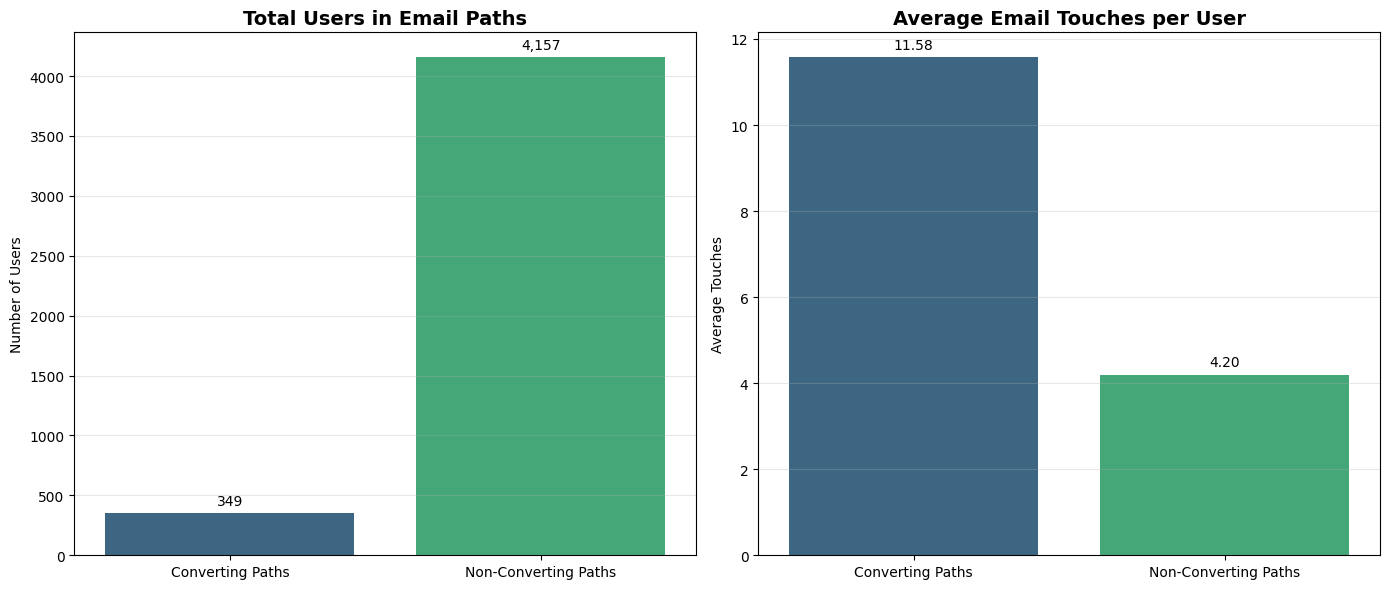

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*50)
print("📈 VISUALIZING PATH CHARACTERISTICS")
print("="*50)

if not df_converting_paths.empty and not df_non_converting_paths.empty:
    data_for_plot = {
        'Type': ['Converting Paths', 'Non-Converting Paths'],
        'Users': [total_users_conv, total_users_non_conv],
        'Avg Email Touches': [weighted_avg_email_touches_conv, weighted_avg_email_touches_non_conv]
    }
    df_plot = pd.DataFrame(data_for_plot)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Bar chart for Total Users
    sns.barplot(x='Type', y='Users', data=df_plot, ax=axes[0], palette='viridis')
    axes[0].set_title('Total Users in Email Paths', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Number of Users')
    axes[0].set_xlabel('')
    for p in axes[0].patches:
        axes[0].annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points')
    axes[0].grid(axis='y', alpha=0.3)


    # Bar chart for Average Email Touches
    sns.barplot(x='Type', y='Avg Email Touches', data=df_plot, ax=axes[1], palette='viridis')
    axes[1].set_title('Average Email Touches per User', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Average Touches')
    axes[1].set_xlabel('')
    for p in axes[1].patches:
        axes[1].annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points')
    axes[1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()
elif df_converting_paths.empty and df_non_converting_paths.empty:
    print("No email campaign paths to visualize.")
else:
    print("Not enough data to compare (one of the categories is empty).")

**Reasoning**:
The previous step's `sns.barplot` calls generated `FutureWarning` due to deprecated usage of the `palette` argument without `hue`. I will update the `sns.barplot` calls to include `hue='Type'` and `legend=False` to resolve these warnings. After fixing the warning, I will proceed to the next logical step in the task, which is to summarize the key differences between converting and non-converting email campaign paths, as outlined in the initial task description.




📈 VISUALIZING PATH CHARACTERISTICS


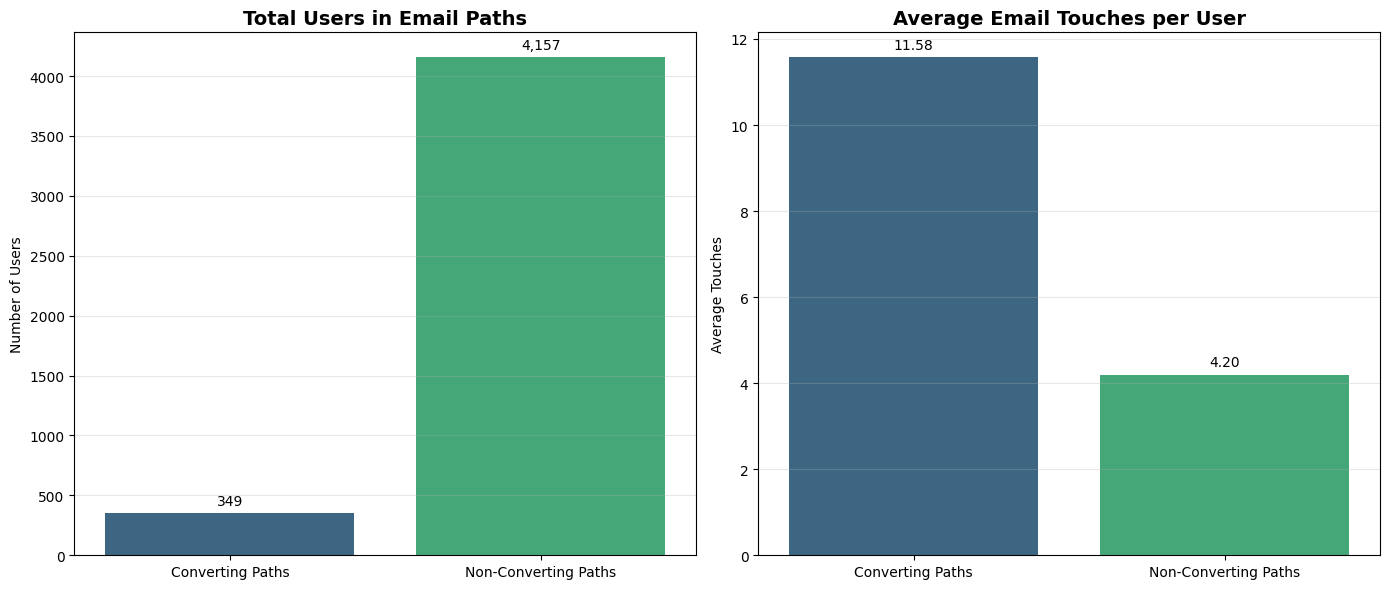


💡 KEY DIFFERENCES & INSIGHTS
Summary of Converting vs. Non-Converting Email Campaign Paths:

- **User Distribution**: A substantial number of users (4,157) interacted with email campaigns but did not convert, significantly more than those who did convert (349). This highlights a large opportunity for re-engagement and optimization.
- **Email Touches**: Converting users had a weighted average of 11.58 email touches, while non-converting users had 4.20 touches.
  This suggests that, on average, more email interactions (11.58 vs 4.20) tend to precede a conversion.
- **Revenue and Gift Size**: Converting paths generated a total of $12,780.00 from 240 conversions, with an average gift size of $53.25 per conversion.

Potential Strategies for Improving Campaign Effectiveness:
  - **Nurturing non-converters**: Design specific nurture campaigns for users who have engaged multiple times (like non-converters with 4.20 avg touches) but haven't converted. Focus on personalized content, clear value

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*50)
print("📈 VISUALIZING PATH CHARACTERISTICS")
print("="*50)

if not df_converting_paths.empty and not df_non_converting_paths.empty:
    data_for_plot = {
        'Type': ['Converting Paths', 'Non-Converting Paths'],
        'Users': [total_users_conv, total_users_non_conv],
        'Avg Email Touches': [weighted_avg_email_touches_conv, weighted_avg_email_touches_non_conv]
    }
    df_plot = pd.DataFrame(data_for_plot)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Bar chart for Total Users
    sns.barplot(x='Type', y='Users', data=df_plot, ax=axes[0], hue='Type', palette='viridis', legend=False)
    axes[0].set_title('Total Users in Email Paths', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Number of Users')
    axes[0].set_xlabel('')
    for p in axes[0].patches:
        axes[0].annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points')
    axes[0].grid(axis='y', alpha=0.3)


    # Bar chart for Average Email Touches
    sns.barplot(x='Type', y='Avg Email Touches', data=df_plot, ax=axes[1], hue='Type', palette='viridis', legend=False)
    axes[1].set_title('Average Email Touches per User', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Average Touches')
    axes[1].set_xlabel('')
    for p in axes[1].patches:
        axes[1].annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points')
    axes[1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()
elif df_converting_paths.empty and df_non_converting_paths.empty:
    print("No email campaign paths to visualize.")
else:
    print("Not enough data to compare (one of the categories is empty).")

print("\n" + "="*50)
print("💡 KEY DIFFERENCES & INSIGHTS")
print("="*50)

if not df_converting_paths.empty and not df_non_converting_paths.empty:
    print("Summary of Converting vs. Non-Converting Email Campaign Paths:")
    print(f"\n- **User Distribution**: A substantial number of users ({total_users_non_conv:,}) interacted with email campaigns but did not convert, significantly more than those who did convert ({total_users_conv:,}). This highlights a large opportunity for re-engagement and optimization.")
    print(f"- **Email Touches**: Converting users had a weighted average of {weighted_avg_email_touches_conv:.2f} email touches, while non-converting users had {weighted_avg_email_touches_non_conv:.2f} touches.")
    if weighted_avg_email_touches_conv > weighted_avg_email_touches_non_conv:
        print(f"  This suggests that, on average, more email interactions ({weighted_avg_email_touches_conv:.2f} vs {weighted_avg_email_touches_non_conv:.2f}) tend to precede a conversion.")
    elif weighted_avg_email_touches_conv < weighted_avg_email_touches_non_conv:
        print(f"  This suggests that converting users might be reached more efficiently or convert sooner ({weighted_avg_email_touches_conv:.2f} vs {weighted_avg_email_touches_non_conv:.2f}), while non-converters might be receiving more emails without impact.")
    else:
        print(f"  The average number of email touches is very similar for both groups, implying touchpoint quantity alone might not be the deciding factor.")
    print(f"- **Revenue and Gift Size**: Converting paths generated a total of ${total_revenue_conv:,.2f} from {total_conversions:,} conversions, with an average gift size of ${weighted_avg_gift_size_conv:,.2f} per conversion.")

    print("\nPotential Strategies for Improving Campaign Effectiveness:")
    if weighted_avg_email_touches_conv > weighted_avg_email_touches_non_conv:
        print(f"  - **Nurturing non-converters**: Design specific nurture campaigns for users who have engaged multiple times (like non-converters with {weighted_avg_email_touches_non_conv:.2f} avg touches) but haven't converted. Focus on personalized content, clear value propositions, or incentives.")
        print(f"  - **Content & CTA Optimization**: For converting paths, identify common themes or calls-to-action that led to conversion and amplify them in future campaigns. Ensure content relevance increases with each touchpoint.")
    elif weighted_avg_email_touches_conv < weighted_avg_email_touches_non_conv:
        print(f"  - **Streamlining non-converting paths**: Investigate why non-converters require more touches. Are the messages unclear, too frequent, or lacking a compelling call to action? Consider reducing touchpoints or redesigning the journey for efficiency.")
        print(f"  - **Identify early conversion drivers**: For converting paths, analyze what makes fewer touches effective. Can this efficiency be replicated across more campaigns?")
    else: # Touches are similar
        print(f"  - **Deep dive into content and audience**: Since touchpoints are similar, the difference likely lies in content, targeting, or external factors. Perform A/B testing on email content, subject lines, and send times to improve engagement and conversion rates.")
        print(f"  - **Segmentation Refinement**: Further segment your audience to deliver highly personalized content that addresses their specific needs and stage in the donor journey, rather than a one-size-fits-all approach.")
else:
    print("Not enough data to provide detailed insights for comparison.")

## Summary:

### Data Analysis Key Findings
*   **User Distribution**: Out of a total of 4,506 users across all paths, 349 users were in converting paths, while a significantly larger number, 4,157 users, were in non-converting paths. This indicates that a large majority of users who interact with email campaigns do not convert.
*   **Conversion Metrics**: Converting paths resulted in 240 total conversions, generating \$12,780.00 in total revenue, with an average gift size of \$53.25 per conversion.
*   **Email Touches (Converting vs. Non-Converting)**: Users in converting paths experienced a weighted average of 11.58 email touches, which is substantially higher than the 4.20 average email touches for users in non-converting paths. This suggests that more email interactions are generally associated with a higher likelihood of conversion.

### Insights or Next Steps
*   **Nurturing Non-Converters**: Implement targeted nurture campaigns for the 4,157 non-converting users who averaged 4.20 email touches. These campaigns should focus on personalized content, clear value propositions, or incentives to encourage conversion.
*   **Content & Call-to-Action (CTA) Optimization**: Analyze the common themes and CTAs in converting paths (which had an average of 11.58 email touches) to identify successful strategies. Amplify these elements in future campaigns, ensuring content relevance increases with each touchpoint to drive higher conversion rates.
